### Basic Metropolis-Hastings MCMC 
use random walk  based proposals  

points for illustration:
- tightness of priors, effect on posterior and dependencies
- size of random walk variance and mixing (0.001 works OK)
- monitoring the acceptance probabiliy

In [2]:
using DifferentialEquations, PyPlot, Distributions, LaTeXStrings, Statistics, CSV

In [5]:
theta = [0.25, 0.1] # γ, λ
T = 365*4
t = collect(0:1:365*4)
P0 = 1.0;

In [6]:
simulate(u,p,t) = p[1]*(1+sin(2*π/365*t))*u - p[2]*u^2

simulate (generic function with 1 method)

In [7]:
function loglike(theta, obs)
    u₀ = 2.5;
    tspan = (0.0, T)
    p = [theta[1], theta[2]]
    prob = ODEProblem(simulate,u₀,tspan,p)
    xhat = solve(prob,reltol=1e-6,saveat=15.0).u
    L = -sum((obs[:,2] .- xhat).^2)
    return L
end

loglike (generic function with 1 method)

### load in some (synthetic) observations

In [8]:
data = CSV.read("data/obs.csv")
obs = hcat(data[:,1],data[:,2]);

### The H-M algorithm

In [9]:
# setup
nc = 1000 # number of iterations (length of the chain)
theta_acc = zeros(nc,2) # accumulator for posterior samples (parameters)
theta_old = [0.25, 0.1]# initial condition for chain (parameter values)

# priors (use uniforms so set upper and lower bounds)
gamma_bar = 0.25 # gamma mean
lambda_bar = 0.1 # lambda mean
gam_sd = 0.05
lam_sd = 0.02

# random walk std
rw_sd = 0.001;

In [10]:
for i in 1:nc
    # Step 1: Generate Trial Candidate  
    # use random walk based on previous value of the chain

    theta_c = theta_old .+ rw_sd .* randn(2)
    
    # Step 2: Compute acceptance probability for this candidate
    # log likelihood for for candidate/trail particle
    like_num = loglike(theta_c, obs)
    p_gam = logpdf(Normal(gamma_bar,gam_sd),theta_c[1])
    p_lam = logpdf(Normal(lambda_bar,lam_sd),theta_c[2])
    prior_num = p_gam + p_lam 
    
    # log likelihood for current particle (last member of the chain/sample)
    like_denom = loglike(theta_old, obs)
    p_gam = logpdf(Normal(gamma_bar,gam_sd),theta_old[1])
    p_lam = logpdf(Normal(lambda_bar,lam_sd),theta_old[2])
    prior_denom = p_gam + p_lam
    
    # ratio of posteriors (candidate vs current)
    ratio = exp((like_num+prior_num) - (like_denom+prior_denom))
    
    A = min(1,ratio) # acceptance probability
    
    # Step 3: Choose whether to accept candidate
    # accept candidate with probability A, otherwise revert to previous chain member
    if rand(Uniform()) <= A
        theta_new = theta_c
    else
        theta_new = theta_old
    end

    # add result to the sample accumulator
    theta_acc[i,:] = theta_new
    theta_old = theta_new # make new particle the current particle for iterations
end

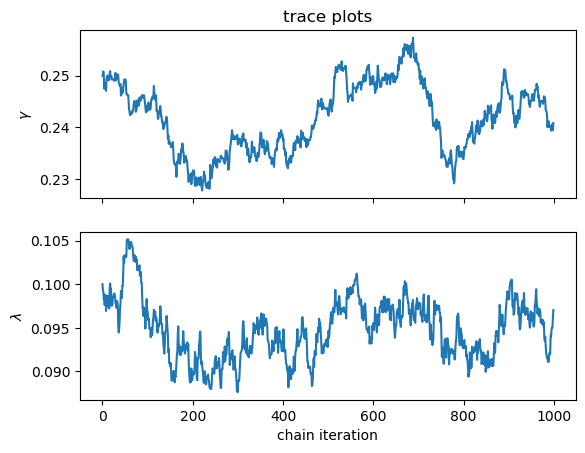

In [11]:
fig, axs = plt.subplots(nrows=2, sharex=true)
axs[1].plot(theta_acc[:,1])
axs[1].set(ylabel=L"\gamma", title="trace plots")
axs[2].plot(theta_acc[:,2])
axs[2].set(ylabel=L"\lambda", xlabel="chain iteration");

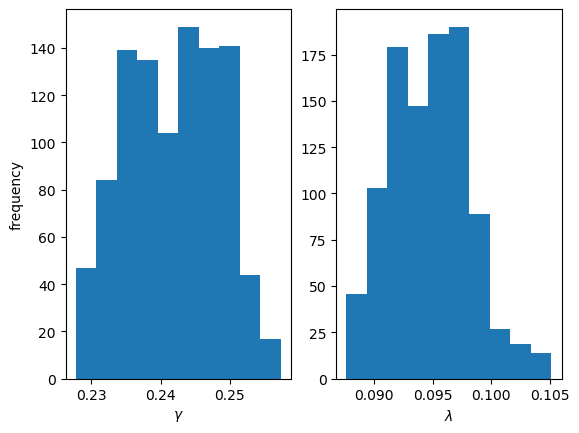

In [12]:
# histograms
cname = [L"\gamma", L"\lambda"]
fig, axs = plt.subplots(ncols=2)
for iax in 1:2
    axs[iax].hist(theta_acc[:,iax])
    axs[iax].set_xlabel(cname[iax])
end
    
axs[1].set_ylabel("frequency");

In [13]:
using KernelDensity

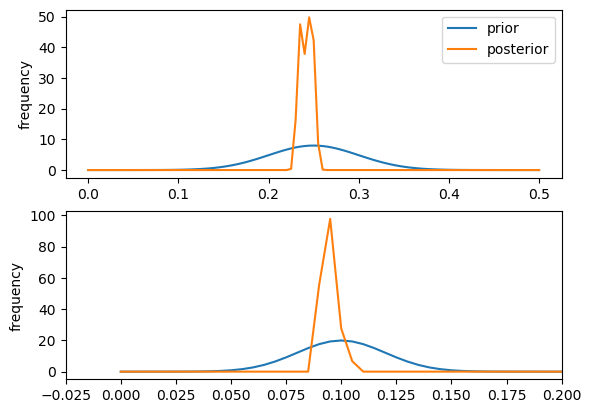

In [14]:
# prior and posterior
x = collect(0.0:0.005:0.5)
fig, axs = plt.subplots(2,1)
axs[1].plot(x,pdf.(Normal(gamma_bar,gam_sd),x), label="prior")
axs[2].plot(x,pdf.(Normal(lambda_bar,lam_sd),x), label="prior")
for i in 1:2
    # kernel smooth density
    ksd = kde(theta_acc[:,i])
    axs[i].plot(x,pdf(ksd,x),label="posterior")
    axs[i].set(ylabel="frequency")
end
axs[2].set_xlim(right=0.2)
axs[1].legend();
plt.show()

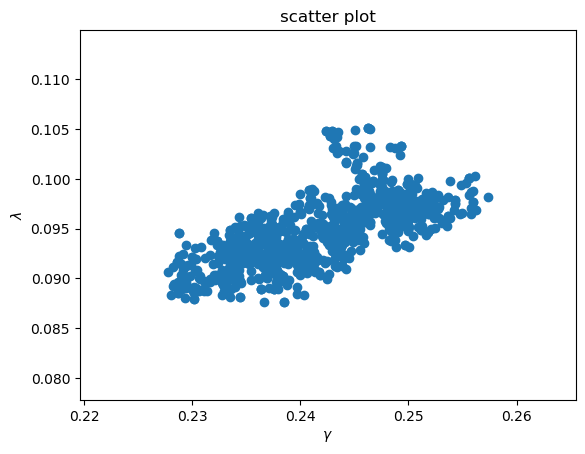

In [15]:
# scatter plot of joint distribution
fig, ax = plt.subplots()
ax.scatter(theta_acc[:,1], theta_acc[:,2])
ax.set(title="scatter plot", xlabel=L"\gamma", ylabel=L"\lambda");